### To Do

- Implementar +2 modelos de identificacao de derivas (DDM e EDDM)

- Estudar (livre) sobre tipos de anomalias

- Gerar modelo de classificacao que fica "girando"

### Notes
- Histórico de outliers -- Evitar derivas indesejáveis (exemplo da corrente elétrica)
- Tipos de outlier -- Como diferenciar diferenciar dos outliers
  - Anomalia pontual (comum)
  - Anomalia contextual (foge do esperado baseado no contexto)
  - Anomalia coletiva (subconjunto inteiro tem uma caracteristica anomala)



In [2]:
# !pip install sklearn

### Imports

In [3]:
import random
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt

random.seed(777)

### Normal Timeseries

In [4]:
# Observations
def observations(initial=100, final=110, observations=100, times=10):
  aux = list()
  for i in range(times):
    aux.append([random.randint(initial, final) for i in range(observations)])
  return np.array(aux)

# Drift
def drift(data, times=1, step=10, window=10):
  aux = list()
  last = data[-1]
  observations = len(last)
  q25 = np.quantile(last, 0.25)
  initial = int(q25)
  for i in range(times):
    aux.append([random.randint(initial, initial + window) for i in range(observations)])
    initial += step

  data = np.append(data, np.array(aux), axis=0)
  return data

# Outliers
def outliers(data, times=5):
  iqr = stats.iqr(data)
  q25 = np.quantile(data, 0.25)
  q75 = np.quantile(data, 0.75)

  upper_bound = q75 + (1.5 * iqr)
  lower_bound = q25 - (1.5 * iqr)

  for i in range(times):
    data[random.randint(0, len(data)-1)] = upper_bound + iqr
    data[random.randint(0, len(data)-1)] = lower_bound - iqr

  return data

# Basic Outlier Detector
def outlierDetector(data):
  iqr = stats.iqr(data)
  q25 = np.quantile(data, 0.25)
  q75 = np.quantile(data, 0.75)
  upper_bound = q75 + (1.5 * iqr)
  lower_bound = q25 - (1.5 * iqr)

  return np.where((data > upper_bound) | (data < lower_bound) , True, False)

# Z-Score Outlier Detector
def outlierDetectorZscore(data, threshold=3):
  z = np.abs(stats.zscore(data))
  return np.where(z > threshold, True, False)

Normal Data

In [5]:
batch_size = 30

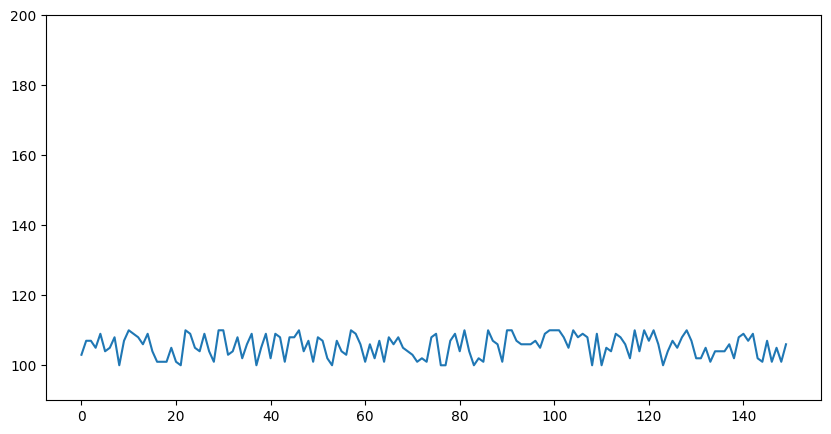

In [6]:
data = observations(times=5, observations=batch_size)

aux = data.flatten()

fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(aux)
plt.ylim(bottom=90, top=200)
plt.show()

Gradual Drift

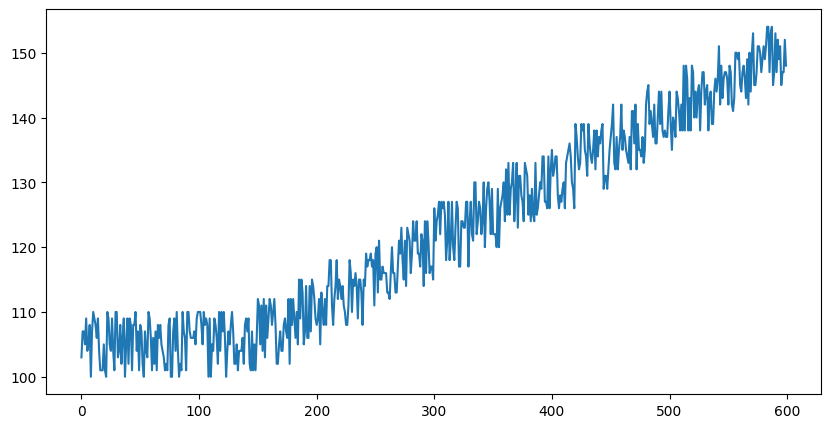

In [7]:
data = drift(data, times=15, step=3, window=10)
data[-1]

aux = data.flatten()

fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(aux)
plt.ylim()
plt.show()

Sudden Drift

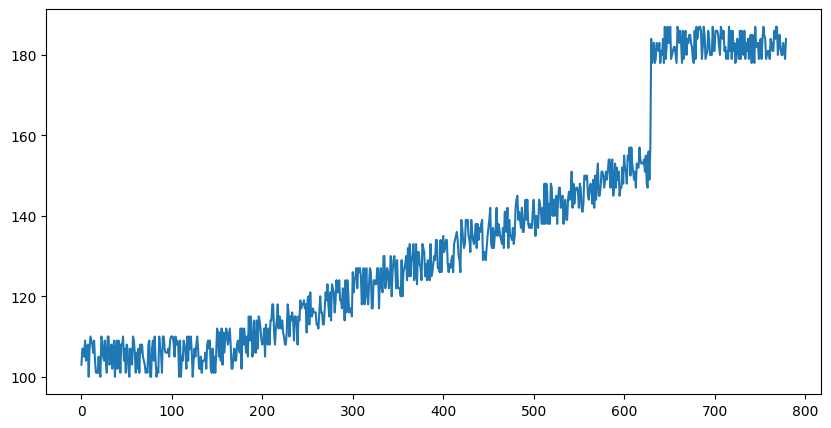

In [8]:
for t in range(1):
  data = drift(data, times=2, step=30, window=10)
  obs = observations(times=4, initial=data[-1].min(), final=data[-1].max(), observations=batch_size)
  data = np.append(data, obs, axis=0)

data[-1]

aux = data.flatten()

fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(aux)
plt.ylim()
plt.show()

Outliers

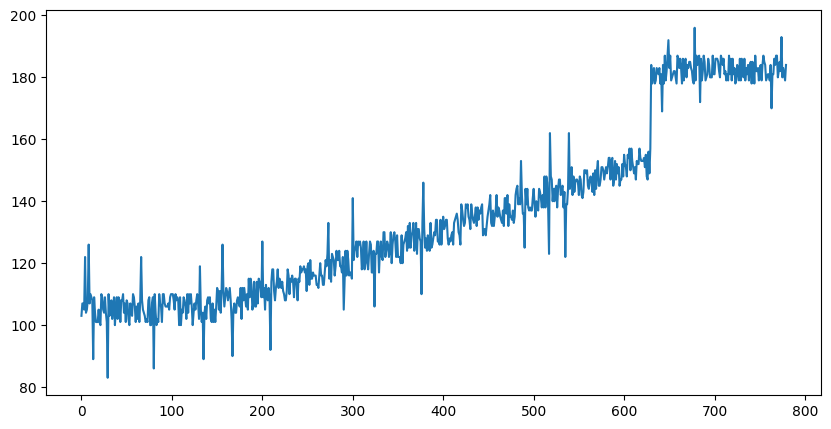

In [9]:
observations_to_add = [random.randint(0, len(data)-1) for t in range(random.randint(10, len(data)))]

for o in observations_to_add:
  data[o] = outliers(data[o], times=1)

aux = data.flatten()

fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(aux)
plt.ylim()
plt.show()

Detect Outliers

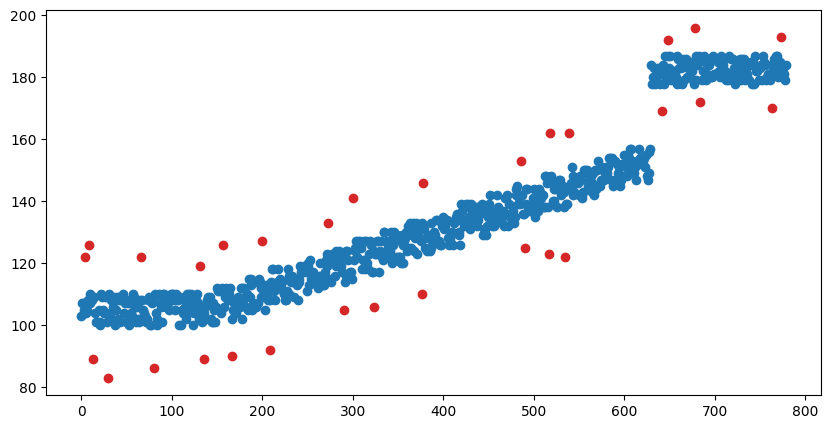

In [10]:
fig, ax = plt.subplots(figsize=(10, 5))
outliers = []

for d in range(len(data)):
  outliers.append(outlierDetector(data[d]))

aux = data.flatten
aux_outliers = np.array(outliers).flatten()

for i, value in enumerate(aux()):
  color = '#d62728' if aux_outliers[i] else '#1f77b4'
  ax.plot(i, value, marker='o', color=color)

plt.show()

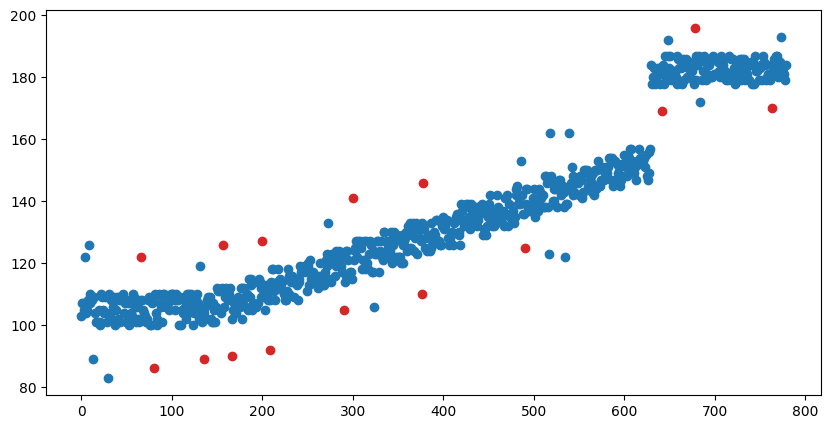

In [11]:
fig, ax = plt.subplots(figsize=(10, 5))
outliers = []

for d in range(len(data)):
  outliers.append(outlierDetectorZscore(data[d]))

aux = data.flatten
aux_outliers = np.array(outliers).flatten()

for i, value in enumerate(aux()):
  color = '#d62728' if aux_outliers[i] else '#1f77b4'
  ax.plot(i, value, marker='o', color=color)

plt.show()

### Implement Detectors

#### DBSCAN

In [12]:
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors

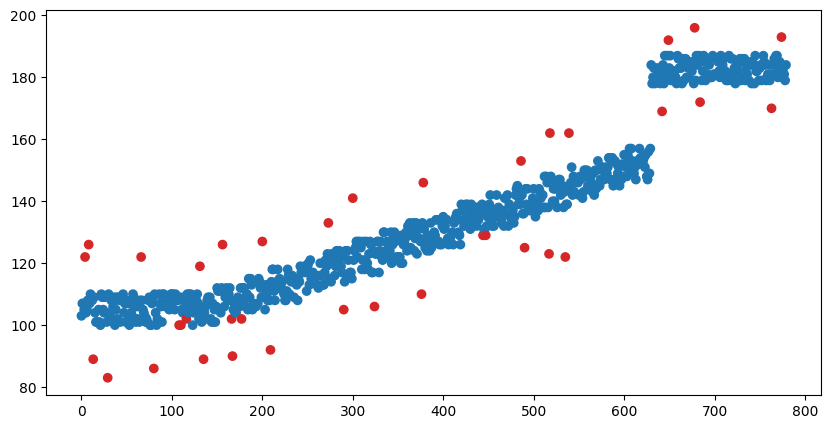

In [13]:
clusters = np.array([])

for d in data:
  X = d.reshape(-1, 1)
  dbscan = DBSCAN(eps=1, min_samples=3)
  clusters_aux = dbscan.fit_predict(X)
  if clusters.shape[0] == 0:
    clusters = clusters_aux
  else:
    clusters = np.append(clusters, clusters_aux, axis=0)

fig, ax = plt.subplots(figsize=(10, 5))

color = ['#d62728' if cl == -1 else '#1f77b4' for cl in clusters]
flat = data.flatten()

ax.scatter(range(len(flat)), flat, c=color, marker='o')

plt.show()

#### IFO

In [14]:
from sklearn.ensemble import IsolationForest

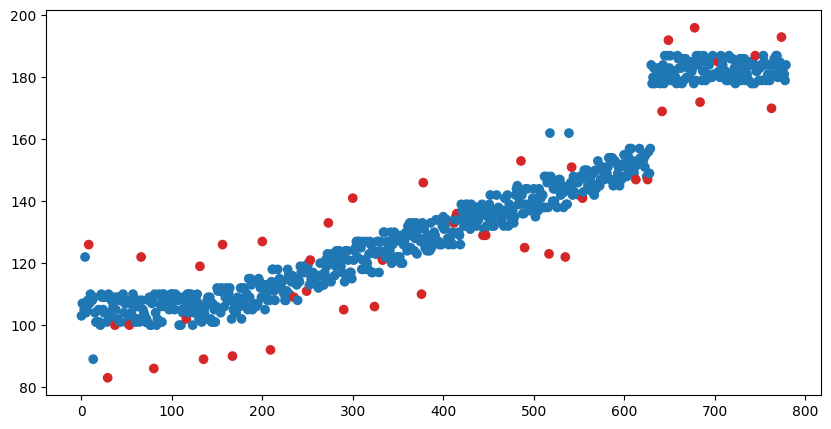

In [15]:
iso = IsolationForest(contamination=0.05, random_state=777)

predictions = np.array([])

for d in data:
  X = d.reshape(-1,1)
  iso.fit(X)
  predictions_aux = iso.predict(X)
  if predictions.shape[0] == 0:
    predictions = predictions_aux
  else:
    predictions = np.append(predictions, predictions_aux, axis=0)

fig, ax = plt.subplots(figsize=(10, 5))

color = ['#d62728' if p == -1 else '#1f77b4' for p in predictions]
flat = data.flatten()

ax.scatter(range(len(flat)), flat, c=color, marker='o')

plt.show()

#### ADWIN

In [16]:
from river import drift

In [36]:
adwin = drift.ADWIN()

flat = data.flatten()

drifts = np.array([])

for d in flat:
  adwin.update(d)

  if adwin.drift_detected:
    drifts = np.append(drifts, 1)
  else:
    drifts = np.append(drifts, 0)

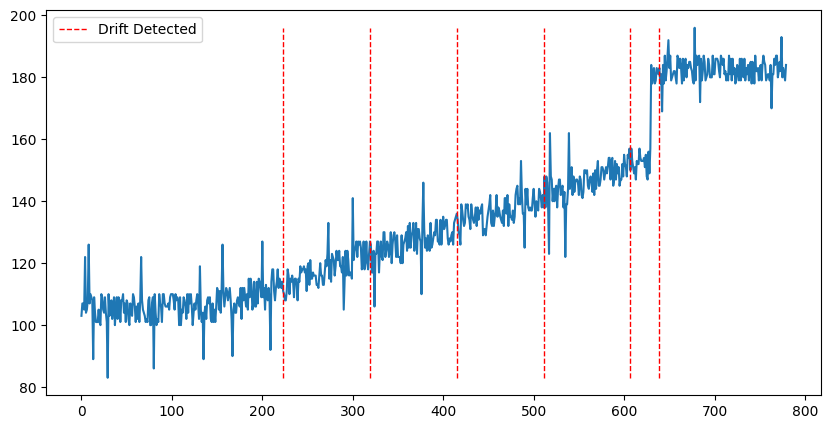

In [18]:
fig, ax = plt.subplots(figsize=(10, 5))

ax.plot(flat)

lines = np.where(drifts == 1)[0]
ax.vlines(lines, ymin=min(flat), ymax=max(flat),
          color='red', linestyle='--', linewidth=1, label='Drift Detected')

ax.legend()
plt.show()

### Linear Regression

In [19]:
from sklearn.linear_model import LinearRegression

flat = data.flatten()

X = flat[:-1].reshape(-1,1)
y = flat[1:]

X_train = X[:100]
y_train = y[:100]

X_test = X[100:]
y_test = y[100:]

model = LinearRegression()
model.fit(X_train, y_train)

predictions = model.predict(X_test)

error = 1 - (predictions / y_test)

### DDM

In [49]:
from river.drift.binary import DDM, EDDM

ddm = DDM()
correct = (error > 0.1).astype(int)

warns = np.array([0 for i in range(101)])
drifts = np.array([0 for i in range(101)])

for i, c in enumerate(correct):
    ddm.update(c)
    if ddm.warning_detected and print_warning:
        warns = np.append(warns, 1)
    else:
        warns = np.append(warns, 0)
    if ddm.drift_detected:
        drifts = np.append(drifts, 1)
    else:
        drifts = np.append(drifts, 0)

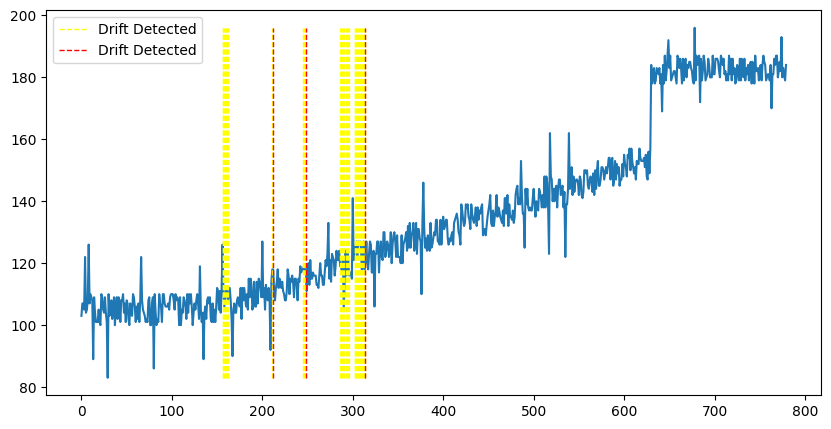

In [52]:
fig, ax = plt.subplots(figsize=(10, 5))

ax.plot(flat)

drift_l = np.where(drifts == 1)[0]
warns_l = np.where(warns == 1)[0]

ax.vlines(warns_l, ymin=min(flat), ymax=max(flat),
          color='yellow', linestyle='--', linewidth=1, label='Drift Detected')
ax.vlines(drift_l, ymin=min(flat), ymax=max(flat),
          color='red', linestyle='--', linewidth=1, label='Drift Detected')

ax.legend()
plt.show()

### EDDM

In [53]:
eddm = EDDM()
correct = (error > 0.1).astype(int)

warns = np.array([0 for i in range(101)])
drifts = np.array([0 for i in range(101)])

for i, c in enumerate(correct):
    eddm.update(c)
    if eddm.warning_detected and print_warning:
        warns = np.append(warns, 1)
    else:
        warns = np.append(warns, 0)
    if eddm.drift_detected:
        drifts = np.append(drifts, 1)
    else:
        drifts = np.append(drifts, 0)

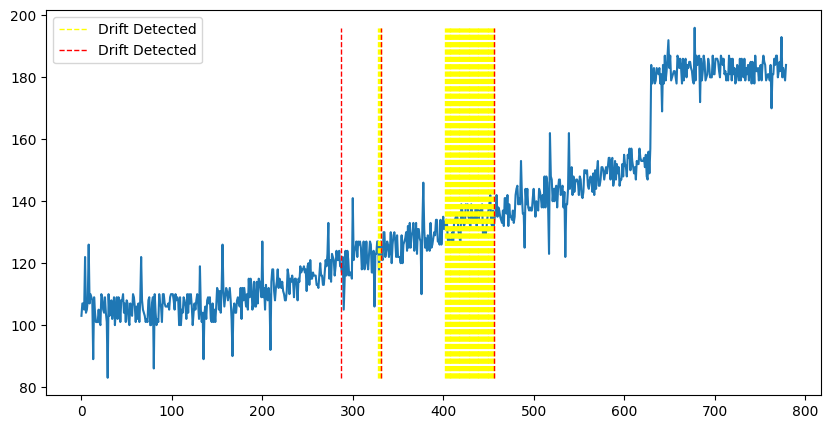

In [54]:
fig, ax = plt.subplots(figsize=(10, 5))

ax.plot(flat)

drift_l = np.where(drifts == 1)[0]
warns_l = np.where(warns == 1)[0]

ax.vlines(warns_l, ymin=min(flat), ymax=max(flat),
          color='yellow', linestyle='--', linewidth=1, label='Drift Detected')
ax.vlines(drift_l, ymin=min(flat), ymax=max(flat),
          color='red', linestyle='--', linewidth=1, label='Drift Detected')

ax.legend()
plt.show()